### <center>ICCS 261 Term Project</center>
# <center>Meteorite Landings: Patterns and Predictions</center>
#### <center>Submitted by Parit Vacharaskunee, ID 6580209<center>

-----------

#### **Introduction to the Research Question**

To be done...

***Research Question***:
- Can meteorites be classified by its weight, location it landed, and whether it was found or fell?
- 

**Resource: https://data.nasa.gov/Space-Science/Meteorite-Landings/gh4g-9sfh/about_data**

#### **Purpose and Objectives**

***Purpose***: Gain insights into the patterns and characteristics that might help distinguish the types of meteorites. Find patterns or trends that could be useful towards the study of Meteorology.

***Objectives***: The main objective is to determine if the characteristics of meteorites (mass, geolocation, and its found status) can be used to distinguish the different types of meteorites. This will be done by making classification models and determine the possibility by analyzing the respective scores and performance of the models.

----

#### **Data Cleaning and Preparation**

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [127]:
df = pd.read_csv('Meteorite_Landings_20240713.csv')
df

,name,id,nametype,recclass,mass (g),fall,year,reclat,reclong,GeoLocation
0,Aachen,1,Valid,L5,21.0,Fell,1880.0,50.77500,6.08333,"(50.775, 6.08333)"
1,Aarhus,2,Valid,H6,720.0,Fell,1951.0,56.18333,10.23333,"(56.18333, 10.23333)"
2,Abee,6,Valid,EH4,107000.0,Fell,1952.0,54.21667,-113.00000,"(54.21667, -113.0)"
3,Acapulco,10,Valid,Acapulcoite,1914.0,Fell,1976.0,16.88333,-99.90000,"(16.88333, -99.9)"
4,Achiras,370,Valid,L6,780.0,Fell,1902.0,-33.16667,-64.95000,"(-33.16667, -64.95)"
...,...,...,...,...,...,...,...,...,...,...
45711,Zillah 002,31356,Valid,Eucrite,172.0,Found,1990.0,29.03700,17.01850,"(29.037, 17.0185)"
45712,Zinder,30409,Valid,"Pallasite, ungrouped",46.0,Found,1999.0,13.78333,8.96667,"(13.78333, 8.96667)"
45713,Zlin,30410,Valid,H4,3.3,Found,1939.0,49.25000,17.66667,"(49.25, 17.66667)"
45714,Zubkovsky,31357,Valid,L6,2167.0,Found,2003.0,49.78917,41.50460,"(49.78917, 41.5046)"


In [128]:
df = df.drop(['id', 'nametype', 'GeoLocation'], axis = 1) # columns are insignificant is not needed
df.isna().sum()

name           0
recclass       0
mass (g)     131
fall           0
year         291
reclat      7315
reclong     7315
dtype: int64

In [129]:
# filling locations and year with forward fill
df[['reclat', 'reclong', 'year']] = df[['reclat', 'reclong', 'year']].fillna(method = 'ffill')

In [130]:
# using median due to a skewed distribution
med = df['mass (g)'].median() 
df['mass (g)'] = df['mass (g)'].fillna(value = med)

# final drops
df = df.dropna()

In [131]:
df.isna().sum()

name        0
recclass    0
mass (g)    0
fall        0
year        0
reclat      0
reclong     0
dtype: int64

In [132]:
len(df['recclass'].unique())

466

There are [3 main types](https://en.wikipedia.org/wiki/Meteorite_classification#Rubin_classification) of meteorites: iron, stony-iron, and stony meteorites. Each of these 3 are also further classified into other names, as seen in the recclass column in the dataset. Since there are 462 unique classifications, I will regroup these names into 1 of 3 main meteorite types:

Stony:
- Carbonaceous chondrites: CI; CM; CR; CO; CV; CK; CH; Ungrouped Carbonaceous chondrite
- Ordinary chondrites: H; L; LL; HH
- Rumuruti chondrites: R
- Kakangari chondrites: K
- Enstatite chondrites: EH; EL; Ungrouped enstatite chondrites
- IAB/IIICD silicate chondrites
- Ungrouped chondrites
- Primitive achondrites: Acapulcoites; Lodranites; Winonaites; Ungrouped primitive achondrites
- Differentiated meteorites:
- Asteroidal achondrites: Eucrites; Diogenites; Howardites; Angrites; Aubrites; Ureilites; Brachinites
- Martian meteorites: Shergottites; Nakhlites; Chassigny; ALH 84001
- Lunar meteorites: Mare basalts; Impact breccias

Stony irons: 
- Pallasites
- Mesosiderites
- Ungrouped stony irons

Irons:
- Magmatic irons groups: IC; IIAB; IIC; IID; IIF; IIIAB; IIIE; IIIF; IVA; IVB
- Nonmagmatic irons groups: IAB/IIICD; IIE
- Ungrouped irons

In [133]:
uniques = pd.DataFrame(df['recclass'].unique())
# retreive classes with keyword 'iron
iron = uniques[uniques[0].str.contains('Iron')]
iron = pd.concat([iron, uniques[uniques[0].str.contains('iron')]])

# retreive classes with keywords regarding stony irons
stony_iron = uniques[uniques[0].str.contains('Pallasite')]
stony_iron = pd.concat([stony_iron, uniques[uniques[0].str.contains('Mesosiderite')]])

# dropping out irons and stony irons from the main dataset
stone = uniques.drop(iron.index).drop(stony_iron.index)

In [134]:
# renaming the names in recclass. WARNING: if cell is run twice, do a run-all.
df['recclass'] = df['recclass'].replace(iron.values, 'Iron')
df['recclass'] = df['recclass'].replace(stony_iron.values, 'Stony Iron')
df['recclass'] = df['recclass'].replace(stone.values, 'Stone')

In [135]:
df['recclass'].unique() # checking the unique names

array(['Stone', 'Iron', 'Stony Iron'], dtype=object)

----

#### **Data Exploration and Statistical Analysis: Proposal Reflection**


 Stone Median: 30.6 g
 Iron Media n: 8770.0 g
 Stony Iron Median: 492.31 g


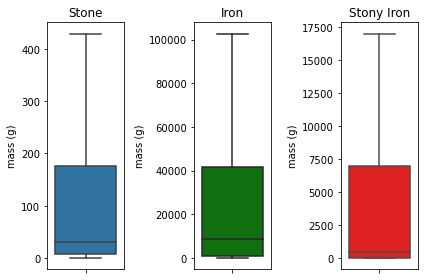

In [136]:
fig, axes = plt.subplots(1, 3, tight_layout = True)
sns.boxplot(ax = axes[0], data = df[df['recclass'] == 'Stone'], y = 'mass (g)', showfliers = False)
sns.boxplot(ax = axes[1], data = df[df['recclass'] == 'Iron'], y = 'mass (g)', showfliers = False, color = 'g')
sns.boxplot(ax = axes[2], data = df[df['recclass'] == 'Stony Iron'], y = 'mass (g)', showfliers = False, color = 'r')

axes[0].set_title('Stone')
axes[1].set_title('Iron')
axes[2].set_title('Stony Iron')

st_med = df[df['recclass'] == 'Stone']['mass (g)'].median()
ir_med = df[df['recclass'] == 'Iron']['mass (g)'].median()
si_med = df[df['recclass'] == 'Stony Iron']['mass (g)'].median()

print(f'\n Stone Median: {st_med} g\n Iron Media n: {ir_med} g\n Stony Iron Median: {si_med} g')

Here we can see the average mass (disregarding outliers) of each types of meteorites. It can be seen that iron meteorites are the heaviest, followed by stony iron, and then stone. This could be a potential use towards making a classification model of each type of meteorites.

----

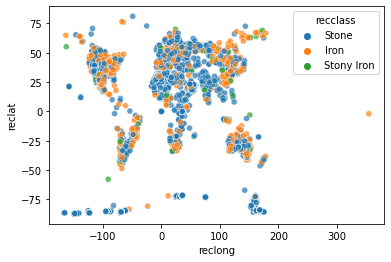

In [137]:
sns.scatterplot(x = df['reclong'], y = df['reclat'], alpha = 0.7, hue = df['recclass'])
plt.show()

The locations of the meteorites do not show any significant pattern, but could prove useful as a parameter in the model as well.

----

See the number of fallen meteors each year. I am not including meteors that was found as the year is not the year that the meteor fell, which can effect the rate of fallen meteors on specific years.

In [138]:
fallen_meteors = df[df['fall'] == 'Fell']
fallen_meteors

,name,recclass,mass (g),fall,year,reclat,reclong
0,Aachen,Stone,21.0,Fell,1880.0,50.77500,6.08333
1,Aarhus,Stone,720.0,Fell,1951.0,56.18333,10.23333
2,Abee,Stone,107000.0,Fell,1952.0,54.21667,-113.00000
3,Acapulco,Stone,1914.0,Fell,1976.0,16.88333,-99.90000
4,Achiras,Stone,780.0,Fell,1902.0,-33.16667,-64.95000
...,...,...,...,...,...,...,...
1106,Zhuanghe,Stone,2900.0,Fell,1976.0,39.66667,122.98333
1107,Zmenj,Stone,246.0,Fell,1858.0,51.83333,26.83333
1108,Zomba,Stone,7500.0,Fell,1899.0,-15.18333,35.28333
1109,Zsadany,Stone,552.0,Fell,1875.0,46.93333,21.50000


In [139]:
years = pd.DataFrame(fallen_meteors['year'].value_counts())
years

,year
1933.0,17
1949.0,13
1976.0,12
1950.0,12
1938.0,11
...,...
1632.0,1
1849.0,1
2013.0,1
920.0,1


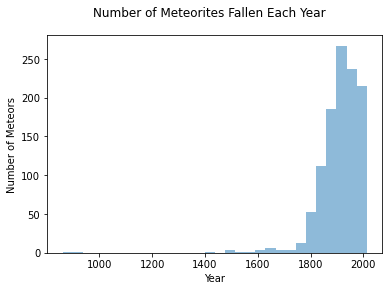

In [140]:
fig, ax = plt.subplots()
fig.suptitle("Number of Meteorites Fallen Each Year")
ax.hist(fallen_meteors['year'], bins = 30, alpha = 0.5)
ax.set(xlabel = 'Year', ylabel = "Number of Meteors")
plt.show()

----

#### **Models**

**Random Forest Model #1: Classification of Meteorites**

In [141]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

Get Independent Variables

In [142]:
fell = pd.get_dummies(df['fall']).drop(columns = 'Found')

x = pd.DataFrame(df['mass (g)'])
x['reclat'] = df['reclat']
x['reclong'] = df['reclong']
x['fell'] = fell
x['year'] = df['year']
x

,mass (g),reclat,reclong,fell,year
0,21.0,50.77500,6.08333,1,1880.0
1,720.0,56.18333,10.23333,1,1951.0
2,107000.0,54.21667,-113.00000,1,1952.0
3,1914.0,16.88333,-99.90000,1,1976.0
4,780.0,-33.16667,-64.95000,1,1902.0
...,...,...,...,...,...
45711,172.0,29.03700,17.01850,0,1990.0
45712,46.0,13.78333,8.96667,0,1999.0
45713,3.3,49.25000,17.66667,0,1939.0
45714,2167.0,49.78917,41.50460,0,2003.0


Get y Variables for Training

In [143]:
y = df.recclass
y

0             Stone
1             Stone
2             Stone
3             Stone
4             Stone
            ...    
45711         Stone
45712    Stony Iron
45713         Stone
45714         Stone
45715         Stone
Name: recclass, Length: 45716, dtype: object

In [144]:
# split train-test
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.3, random_state = 10)

In [145]:
# fitting random forest model with tree size of 100
rf_model = RandomForestClassifier(n_estimators=100) #TODO: change weight to balanced
_ = rf_model.fit(xtrain, ytrain)

Confusion Matrix for Visualization

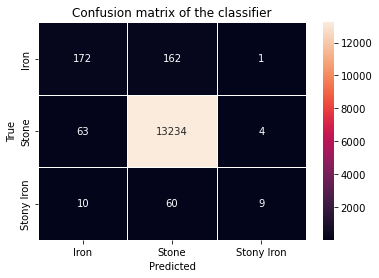

In [146]:
cm = confusion_matrix(ytest, rf_model.predict(xtest))

labels = ['Iron', 'Stone', 'Stony Iron']
sns.heatmap(cm, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels, yticklabels = labels)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Evaluating Test Scores

In [147]:
yhat_test = rf_model.predict(xtest)
print(f'Accuracy: {accuracy_score(ytest, yhat_test)}')
precision_recall_fscore_support(ytest, yhat_test)

Accuracy: 0.97812613926358


(array([0.70204082, 0.98350178, 0.64285714]),
 array([0.51343284, 0.99496278, 0.11392405]),
 array([0.59310345, 0.98919909, 0.19354839]),
 array([  335, 13301,    79], dtype=int64))

The model is able to distinguish stone from the other, but fails to do so for iron and stony iron. It could also be possible that since there is so much more stone meteorites, it outweighs the other two types which causes a bad yield on the other two. Now let's try a model without stones.

----

**Random Forest Model #2: Classifying Stony Iron and Iron Meteorites**

In [148]:
df2 = pd.concat([df[df['recclass'] == 'Stony Iron'], df[df['recclass'] == 'Iron']])

Get Independent Variables

In [149]:
fell2 = pd.get_dummies(df2['fall']).drop(columns = 'Found')

x2 = pd.DataFrame(df2['mass (g)'])
x2['reclat'] = df2['reclat']
x2['reclong'] = df2['reclong']
x2['fell'] = fell2
x2['year'] = df2['year']

Get y Variable for Testing

In [179]:
y2 = df2.recclass

In [177]:
# split train-test
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size = 0.3, random_state = 5)

# fit model
rf_model2 = RandomForestClassifier(n_estimators=100)
_ = rf_model2.fit(xtrain2, ytrain2)

Confusion Matrix for Evaluation

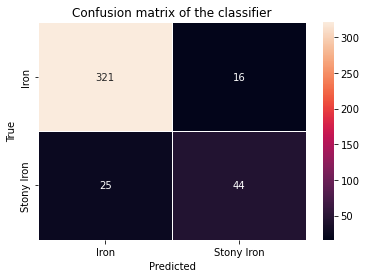

In [178]:
cm2 = confusion_matrix(ytest2, rf_model2.predict(xtest2))

labels2 = ['Iron', 'Stony Iron']
sns.heatmap(cm2, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels2, yticklabels = labels2)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Evaluating Scores

In [153]:
yhat_test2 = rf_model2.predict(xtest2)
print(f'Accuracy: {accuracy_score(ytest2, yhat_test2)}')
precision_recall_fscore_support(ytest2, yhat_test2) #TODO: recheck scores for class0 and class1

Accuracy: 0.9014778325123153


(array([0.92795389, 0.74576271]),
 array([0.95548961, 0.63768116]),
 array([0.94152047, 0.6875    ]),
 array([337,  69], dtype=int64))

According to the model above, by removing stone meteorites, the model was able to perform much better on distinguish the 2 types. However, I believe that this is not a quality model that can be used to help classify the different types of meteorites. ***Add more description and interpretation of the results above***

----

**Random Forest Model #3: Classifying Stone and Iron Meteorites**

For additional information, I will be creating a model between iron and stone meteorites as well as the model tend to perform well to distinguish these two types.

In [154]:
df3 = pd.concat([df[df['recclass'] == 'Stone'], df[df['recclass'] == 'Iron']])

In [155]:
fell3 = pd.get_dummies(df3['fall']).drop(columns = 'Found')

x3 = pd.DataFrame(df3['mass (g)'])
x3['reclat'] = df3['reclat']
x3['reclong'] = df3['reclong']
x3['fell'] = fell3
x3['year'] = df3['year']

In [156]:
y3 = df3.recclass

In [157]:
# split train-test
xtrain3, xtest3, ytrain3, ytest3 = train_test_split(x3, y3, test_size = 0.3, random_state = 100)

# fit model
rf_model3 = RandomForestClassifier(n_estimators=100, class_weight = "balanced") 
_ = rf_model3.fit(xtrain3, ytrain3)

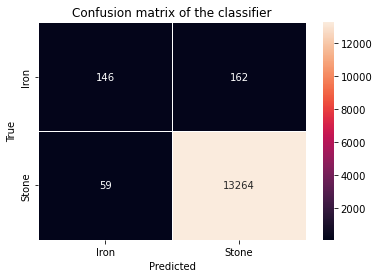

In [158]:
cm3 = confusion_matrix(ytest3, rf_model3.predict(xtest3))

labels3 = ['Iron', 'Stone']
sns.heatmap(cm3, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels3, yticklabels = labels3)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [159]:
yhat_test3 = rf_model3.predict(xtest3)
print(f'Accuracy: {accuracy_score(ytest3, yhat_test3)}')
precision_recall_fscore_support(ytest3, yhat_test3)

Accuracy: 0.9837869562027731


(array([0.71219512, 0.98793386]),
 array([0.47402597, 0.99557157]),
 array([0.56920078, 0.99173801]),
 array([  308, 13323], dtype=int64))

Like above, the model is only able to fit the stone meteorites really well due to the number of data values. For this reason, I decided to add in the weight parameter on the next model to see the performance.

----
**Random Forest Model #4: Classifying Meteorites without Outliers**

Now, let's try removing outliers manually for each types of meteorites by computing for the IQR and removing values that falls outside of it.

In [219]:
# stones
stone_sub = df[df['recclass'] == 'Stone']
iron_sub = df[df['recclass'] == 'Iron']
stonyiron_sub = df[df['recclass'] == 'Stony Iron']

# calculate IQR
stone_IQR = stone_sub['mass (g)'].quantile(0.75) - stone_sub['mass (g)'].quantile(0.25)
iron_IQR = iron_sub['mass (g)'].quantile(0.75) - iron_sub['mass (g)'].quantile(0.25)
stonyiron_IQR = stonyiron_sub['mass (g)'].quantile(0.75) - stonyiron_sub['mass (g)'].quantile(0.25)

# get outliers
stone_outliers = stone_sub.loc[(stone_sub['mass (g)'] < (stone_sub['mass (g)'].quantile(0.25) - 1.5 * stone_IQR)) | (df['mass (g)'] > (stone_sub['mass (g)'].quantile(0.75) + 1.5 * stone_IQR))]
iron_outliers = iron_sub.loc[(iron_sub['mass (g)'] < (iron_sub['mass (g)'].quantile(0.25) - 1.5 * iron_IQR)) | (df['mass (g)'] > (iron_sub['mass (g)'].quantile(0.75) + 1.5 * iron_IQR))]
stonyiron_outliers = stonyiron_sub.loc[(stonyiron_sub['mass (g)'] < (stonyiron_sub['mass (g)'].quantile(0.25) - 1.5 * stonyiron_IQR)) | (df['mass (g)'] > (stonyiron_sub['mass (g)'].quantile(0.75) + 1.5 * stonyiron_IQR))]

In [220]:
# get new dataframe
df_no_outliers = df.drop(stone_outliers.index).drop(iron_outliers.index).drop(stonyiron_outliers.index)
df_no_outliers

,name,recclass,mass (g),fall,year,reclat,reclong
0,Aachen,Stone,21.0,Fell,1880.0,50.77500,6.08333
12,Aire-sur-la-Lys,Stone,32.6,Fell,1769.0,50.66667,2.33333
16,Akyumak,Iron,50000.0,Fell,1981.0,39.91667,42.81667
17,Al Rais,Stone,160.0,Fell,1957.0,24.41667,39.51667
22,Alby sur Chéran,Stone,252.0,Fell,2002.0,45.82133,6.01533
...,...,...,...,...,...,...,...
45709,Zhongxiang,Iron,100000.0,Found,1981.0,31.20000,112.50000
45711,Zillah 002,Stone,172.0,Found,1990.0,29.03700,17.01850
45712,Zinder,Stony Iron,46.0,Found,1999.0,13.78333,8.96667
45713,Zlin,Stone,3.3,Found,1939.0,49.25000,17.66667


In [221]:
fell4 = pd.get_dummies(df_no_outliers['fall']).drop(columns = 'Found')

x4 = pd.DataFrame(df_no_outliers['mass (g)'])
x4['reclat'] = df_no_outliers['reclat']
x4['reclong'] = df_no_outliers['reclong']
x4['fell'] = fell4
x4['year'] = df_no_outliers['year']
x4

,mass (g),reclat,reclong,fell,year
0,21.0,50.77500,6.08333,1,1880.0
12,32.6,50.66667,2.33333,1,1769.0
16,50000.0,39.91667,42.81667,1,1981.0
17,160.0,24.41667,39.51667,1,1957.0
22,252.0,45.82133,6.01533,1,2002.0
...,...,...,...,...,...
45709,100000.0,31.20000,112.50000,0,1981.0
45711,172.0,29.03700,17.01850,0,1990.0
45712,46.0,13.78333,8.96667,0,1999.0
45713,3.3,49.25000,17.66667,0,1939.0


In [222]:
y4 = df_no_outliers.recclass

In [223]:
# split train-test
xtrain4, xtest4, ytrain4, ytest4 = train_test_split(x4, y4, test_size = 0.3, random_state = 10)

In [224]:
# fitting random forest model with tree size of 100
rf_model4 = RandomForestClassifier(n_estimators=100, class_weight='balanced')
_ = rf_model4.fit(xtrain4, ytrain4)

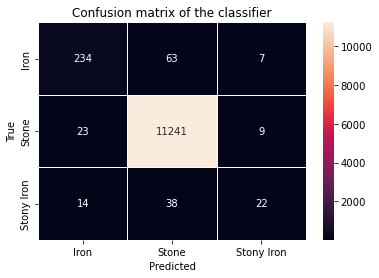

In [225]:
cm4 = confusion_matrix(ytest4, rf_model4.predict(xtest4))

labels4 = ['Iron', 'Stone', 'Stony Iron']
sns.heatmap(cm4, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels4, yticklabels = labels4)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [226]:
yhat_test4 = rf_model4.predict(xtest4)
print(f'Accuracy: {accuracy_score(ytest4, yhat_test4)}')
precision_recall_fscore_support(ytest4, yhat_test4)

Accuracy: 0.9867822504506051


(array([0.86346863, 0.99109504, 0.57894737]),
 array([0.76973684, 0.99716136, 0.2972973 ]),
 array([0.81391304, 0.99411895, 0.39285714]),
 array([  304, 11273,    74], dtype=int64))

By removing the outliers, the scores for the other 2 types were able to improve. However, the score for stony irons seems to still be low. This is potentially because its characteristics is between irons and stones, making it hard for the model to distinguish between.

----
**Random Forest Model #4.5: Model #2 Revisit**

For model 4.5, lets revisit model 2 to try out between only iron and stones.

In [184]:
df4_5 = pd.concat([df_no_outliers[df_no_outliers['recclass'] == 'Stone'], df_no_outliers[df_no_outliers['recclass'] == 'Iron']])

In [185]:
fell4_5 = pd.get_dummies(df4_5['fall']).drop(columns = 'Found')

x4_5 = pd.DataFrame(df4_5['mass (g)'])
x4_5['reclat'] = df4_5['reclat']
x4_5['reclong'] = df4_5['reclong']
x4_5['fell'] = fell4_5
x4_5['year'] = df4_5['year']
x4_5

,mass (g),reclat,reclong,fell,year
0,21.0,50.77500,6.08333,1,1880.0
12,32.6,50.66667,2.33333,1,1769.0
17,160.0,24.41667,39.51667,1,1957.0
22,252.0,45.82133,6.01533,1,2002.0
37,256.8,0.00000,0.00000,0,1939.0
...,...,...,...,...,...
45695,50000.0,30.36667,-5.85000,0,1987.0
45697,85000.0,25.00944,-100.75000,0,1998.0
45698,32.6,27.00000,-99.00000,0,1930.0
45703,3700.0,42.51333,-88.48944,0,1955.0


In [188]:
y4_5 = df4_5.recclass
y4_5

0        Stone
12       Stone
17       Stone
22       Stone
37       Stone
         ...  
45695     Iron
45697     Iron
45698     Iron
45703     Iron
45709     Iron
Name: recclass, Length: 38602, dtype: object

In [189]:
# split train-test
xtrain4_5, xtest4_5, ytrain4_5, ytest4_5 = train_test_split(x4_5, y4_5, test_size = 0.3, random_state = 100)

# fit model
rf_model4_5 = RandomForestClassifier(n_estimators=100, class_weight = "balanced") 
_ = rf_model4_5.fit(xtrain4_5, ytrain4_5)

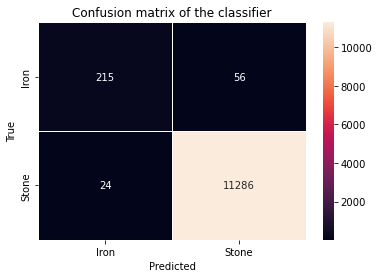

In [190]:
cm4_5 = confusion_matrix(ytest4_5, rf_model4_5.predict(xtest4_5))

labels4_5 = ['Iron', 'Stone']
sns.heatmap(cm4_5, annot = True, fmt = 'd', linewidths = 0.5, xticklabels = labels4_5, yticklabels = labels4_5)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [191]:
yhat_test4_5 = rf_model4_5.predict(xtest4_5)
print(f'Accuracy: {accuracy_score(ytest4_5, yhat_test4_5)}')
precision_recall_fscore_support(ytest4_5, yhat_test4_5)

Accuracy: 0.9930921336672135


(array([0.89958159, 0.9950626 ]),
 array([0.79335793, 0.99787798]),
 array([0.84313725, 0.9964683 ]),
 array([  271, 11310], dtype=int64))

From the scores above, this model seems to perform really well between stones and irons. This suggests that there are distinct features between stones and irons.

------

#### **Interpretation and Analysis**

**Summary of Data**

The data that was used to make each EDA and models is a cleaned version of the original data obtained by NASA's dataset in the link above. The missing data was cleaned in multiple ways: forward filling for the geolocations, as this does not have much significance, and the mass was filled with the median value as the distribution is skewed. Furthermore, it can be seen that meteorites are divided into 3 main types: stones, irons, and stony irons. Since the recclass column in the dataset shows the subtypes of these 3, I decided to replace each subtypes with its corresponding main types so simplify the variables and provide potential better modeling results.

**Summary of EDA**
EDA shown above was to try to observe and find categories that might fit well with the classifier model. It can clearly be seen that when plotting the side by side box plot for the weights of each types, it showed clear differences in the median and the range of the weights. Plotting the geolocation of the meteorites did not really show any signs of distiguishable features, but I believe it is still worth putting in since it could help predict the types based on the relative mean location of its type.

**Summary of Models**
